# Load Cancer Detection Project Into Google Colab


In [ ]:
!pip install kaggle


In [ ]:
from google.colab import files

uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c histopathologic-cancer-detection


100% 6.29G/6.31G [01:26<00:00, 142MB/s]
100% 6.31G/6.31G [01:26<00:00, 78.6MB/s]


In [ ]:
import zipfile

with zipfile.ZipFile('histopathologic-cancer-detection.zip', 'r') as zip_ref:
    zip_ref.extractall('HCD')


# Cancer Detection Using Deep Learning







1. GitHub URL: https://github.com/XieXiao94/5511_-Cancer-Detection-Using-Deep-Learning/blob/main/Cancer_Detection_Using_Deep_Learning_assignment_3.ipynb

2. About this project:

 This project will study 220K image patches with their corresponding labels to build a model to predict whether the metastatic cancer in the images is malignant or benign. The type of learning is deep learning and the type of task is binary image classification.

  
3. Data Source:

 The dataset is from a kaggle project named ' Histopathologic Cancer Detection'.

4. Citation:

 Histopathologic Cancer Detection | Kaggle. (n.d.). https://www.kaggle.com/c/histopathologic-cancer-detection/overview


5. Dataset:

 The dataset contains train images, test images and train_labels.csv. The train and test images are small image patches from the larger digital pathology scans. The train image has 220K+ images and the test image has 57K+ images. Both are in 96 x 96 dimensions, stored in a directory structure and the name of the images are the id with .tif extension.

 The train_labels.csv is corresponding with train image. It is tabulated data and has a data size of 220K rows and 2 columns. Each row is an image and the 2 columns are id and labels of the image.


In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.utils import shuffle

import shutil

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight


import matplotlib.pyplot as plt
from PIL import Image

from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.optimizers import Adam

from keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout


from sklearn.metrics import roc_curve, auc, roc_auc_score


In [ ]:
train_labels = pd.read_csv('HCD/train_labels.csv')
train_labels


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0


In [ ]:
train_labels.shape

(220025, 2)

In [ ]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


### EDA

Text(0, 0.5, 'Count')

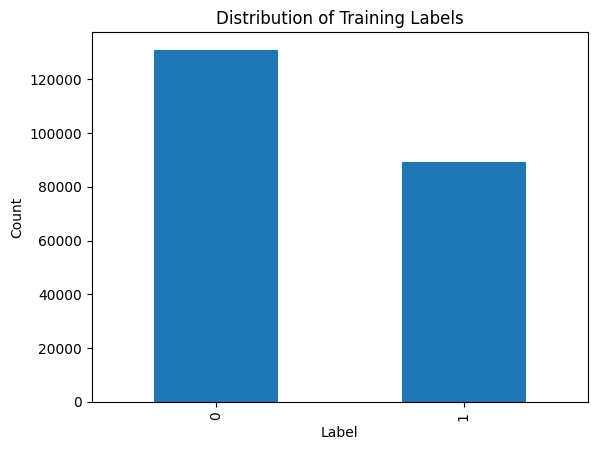

In [ ]:
train_labels['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Training Labels')
plt.xlabel('Label')
plt.ylabel('Count')

In [ ]:
train_labels['label'].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

In [ ]:
# malignant case
M = train_labels['label'] == 1
# benign case
B = train_labels['label'] == 0

Malignant case image


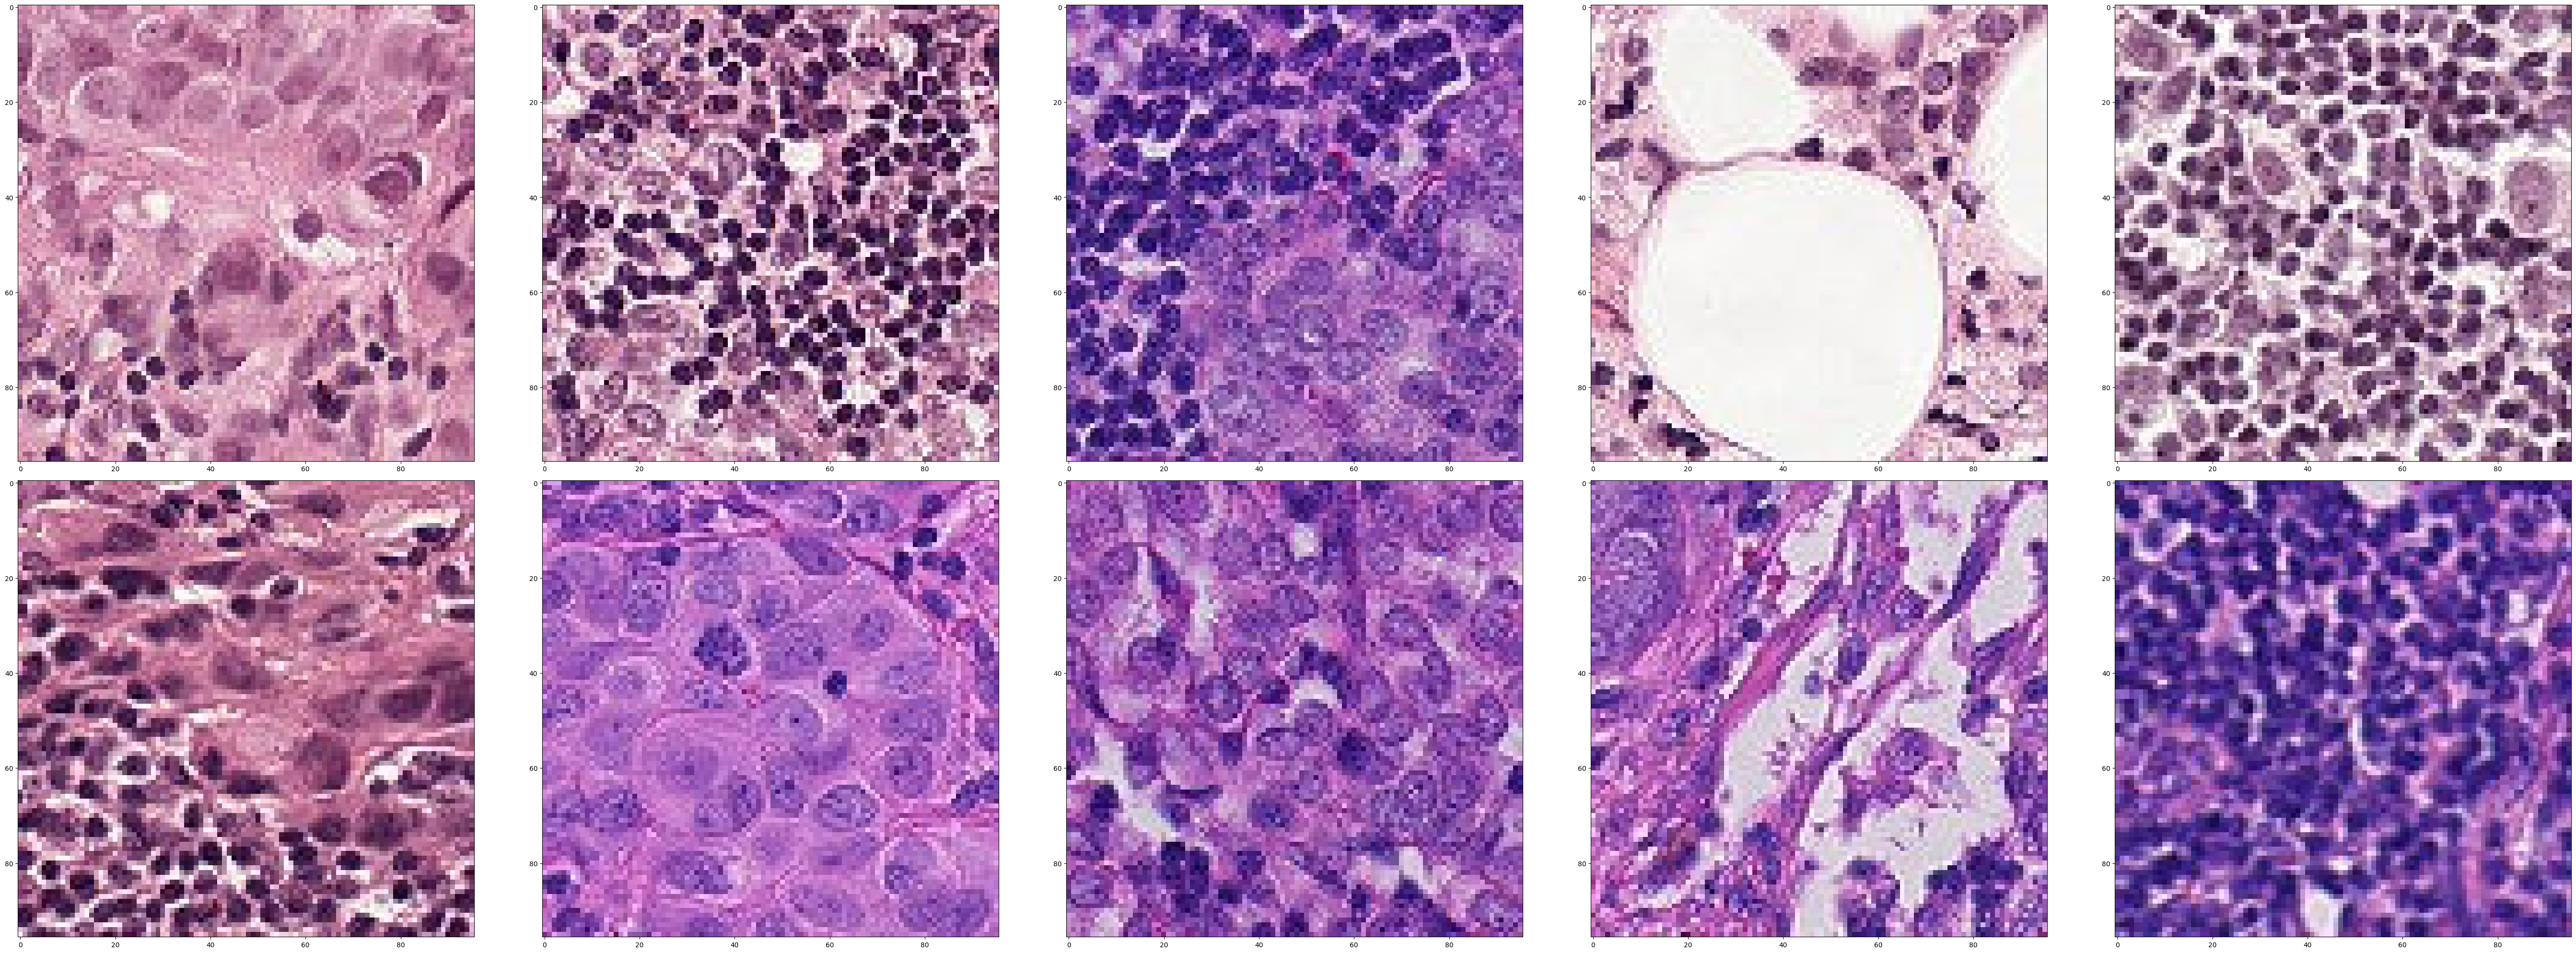

In [ ]:
train = 'HCD/train/'


M_images = train_labels[M].sample(10)['id'].values
print("Malignant case image")

plt.figure(figsize=(55, 20))

for i, id in enumerate(M_images):
    img_path = os.path.join(train, f"{id}.tif")
    img = Image.open(img_path)
    plt.subplot(2,5,i+1)
    plt.imshow(img)


plt.tight_layout()


Benign case image


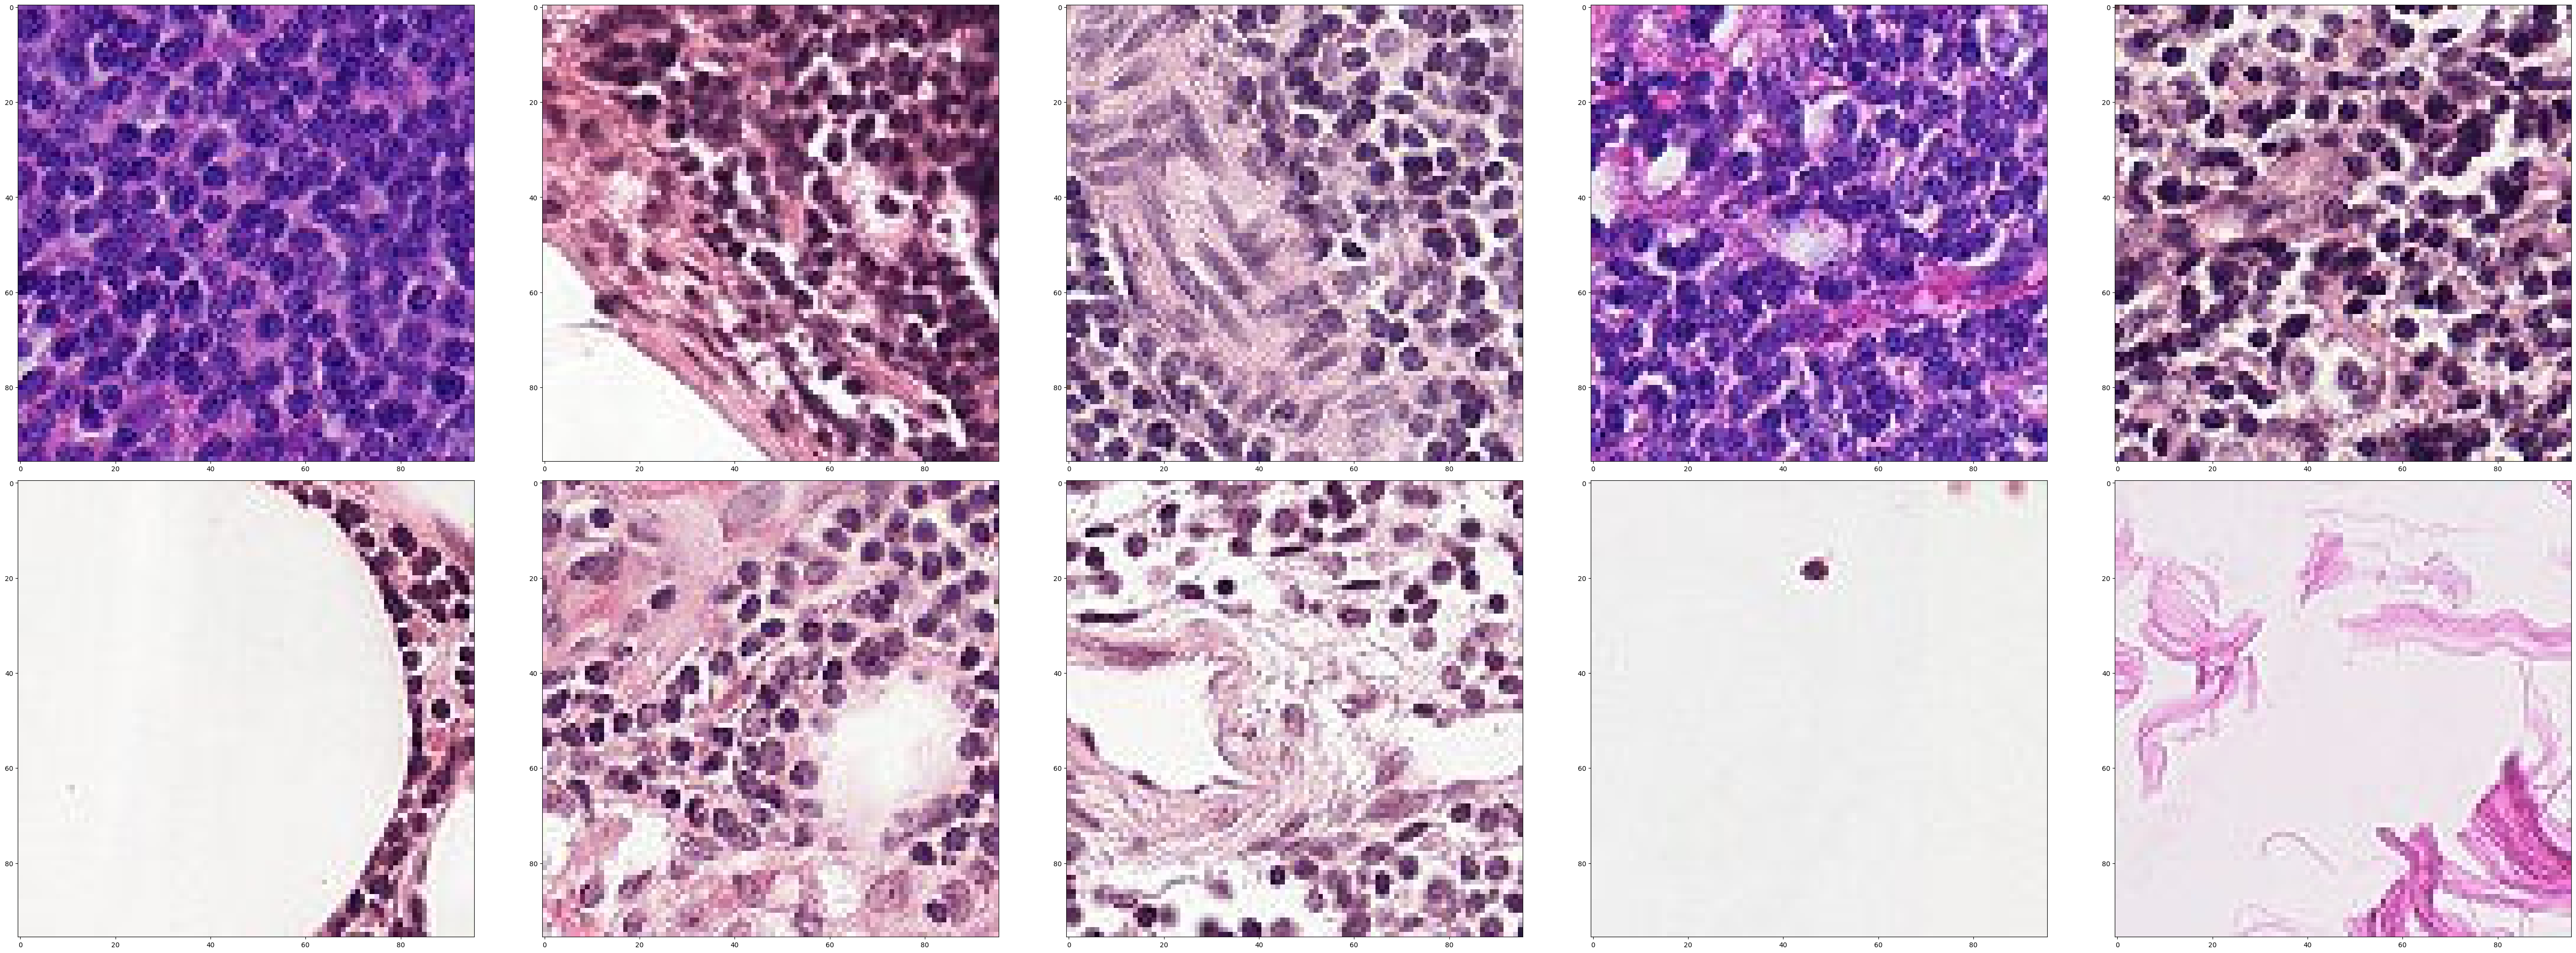

In [ ]:
B_images = train_labels[B].sample(10)['id'].values
print("Benign case image")

plt.figure(figsize=(55, 20))

for i, id in enumerate(B_images):
    img_path = os.path.join(train, f"{id}.tif")
    img = Image.open(img_path)
    plt.subplot(2,5,i+1)
    plt.imshow(img)


plt.tight_layout()

### Data Preprocessing
1. Check null value
2. Check outliers for train directories and remove outliers
3. Check the filenames for train_label and train directories
4. Convert labels from integers to strings
5. Fix the labels imbalance in training data and smaller the dataset for efficiency
6. Split the dataset to train and validation dataset
7. Using Imagedatagenerator for faster and easier transformation, normalizing and preprocessing of the dataset




In [ ]:
# 1. null value

train_labels.isnull().sum()

id       0
label    0
dtype: int64

In [ ]:
# 2. outliers
# black have a pixel value = 0 and white have a pixel value = 255.

black_outliers = []
white_outliers =[]
threshold = 10

for filename in os.listdir(train):
    image_path = os.path.join(train, filename)
    img = Image.open(image_path).convert('L')
    mean = np.mean(img)
    if mean < threshold:
        black_outliers.append(filename)
    elif mean > 255 - threshold:
        white_outliers.append(filename)


number of black image: 1


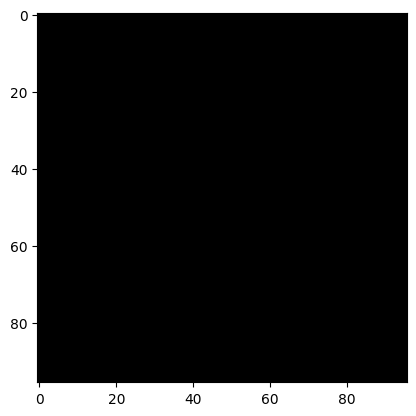

In [ ]:
print('number of black image:', len(black_outliers))
img_path = os.path.join(train, black_outliers[0])
img = Image.open(img_path)
plt.imshow(img)
plt.show()

number of white image: 640


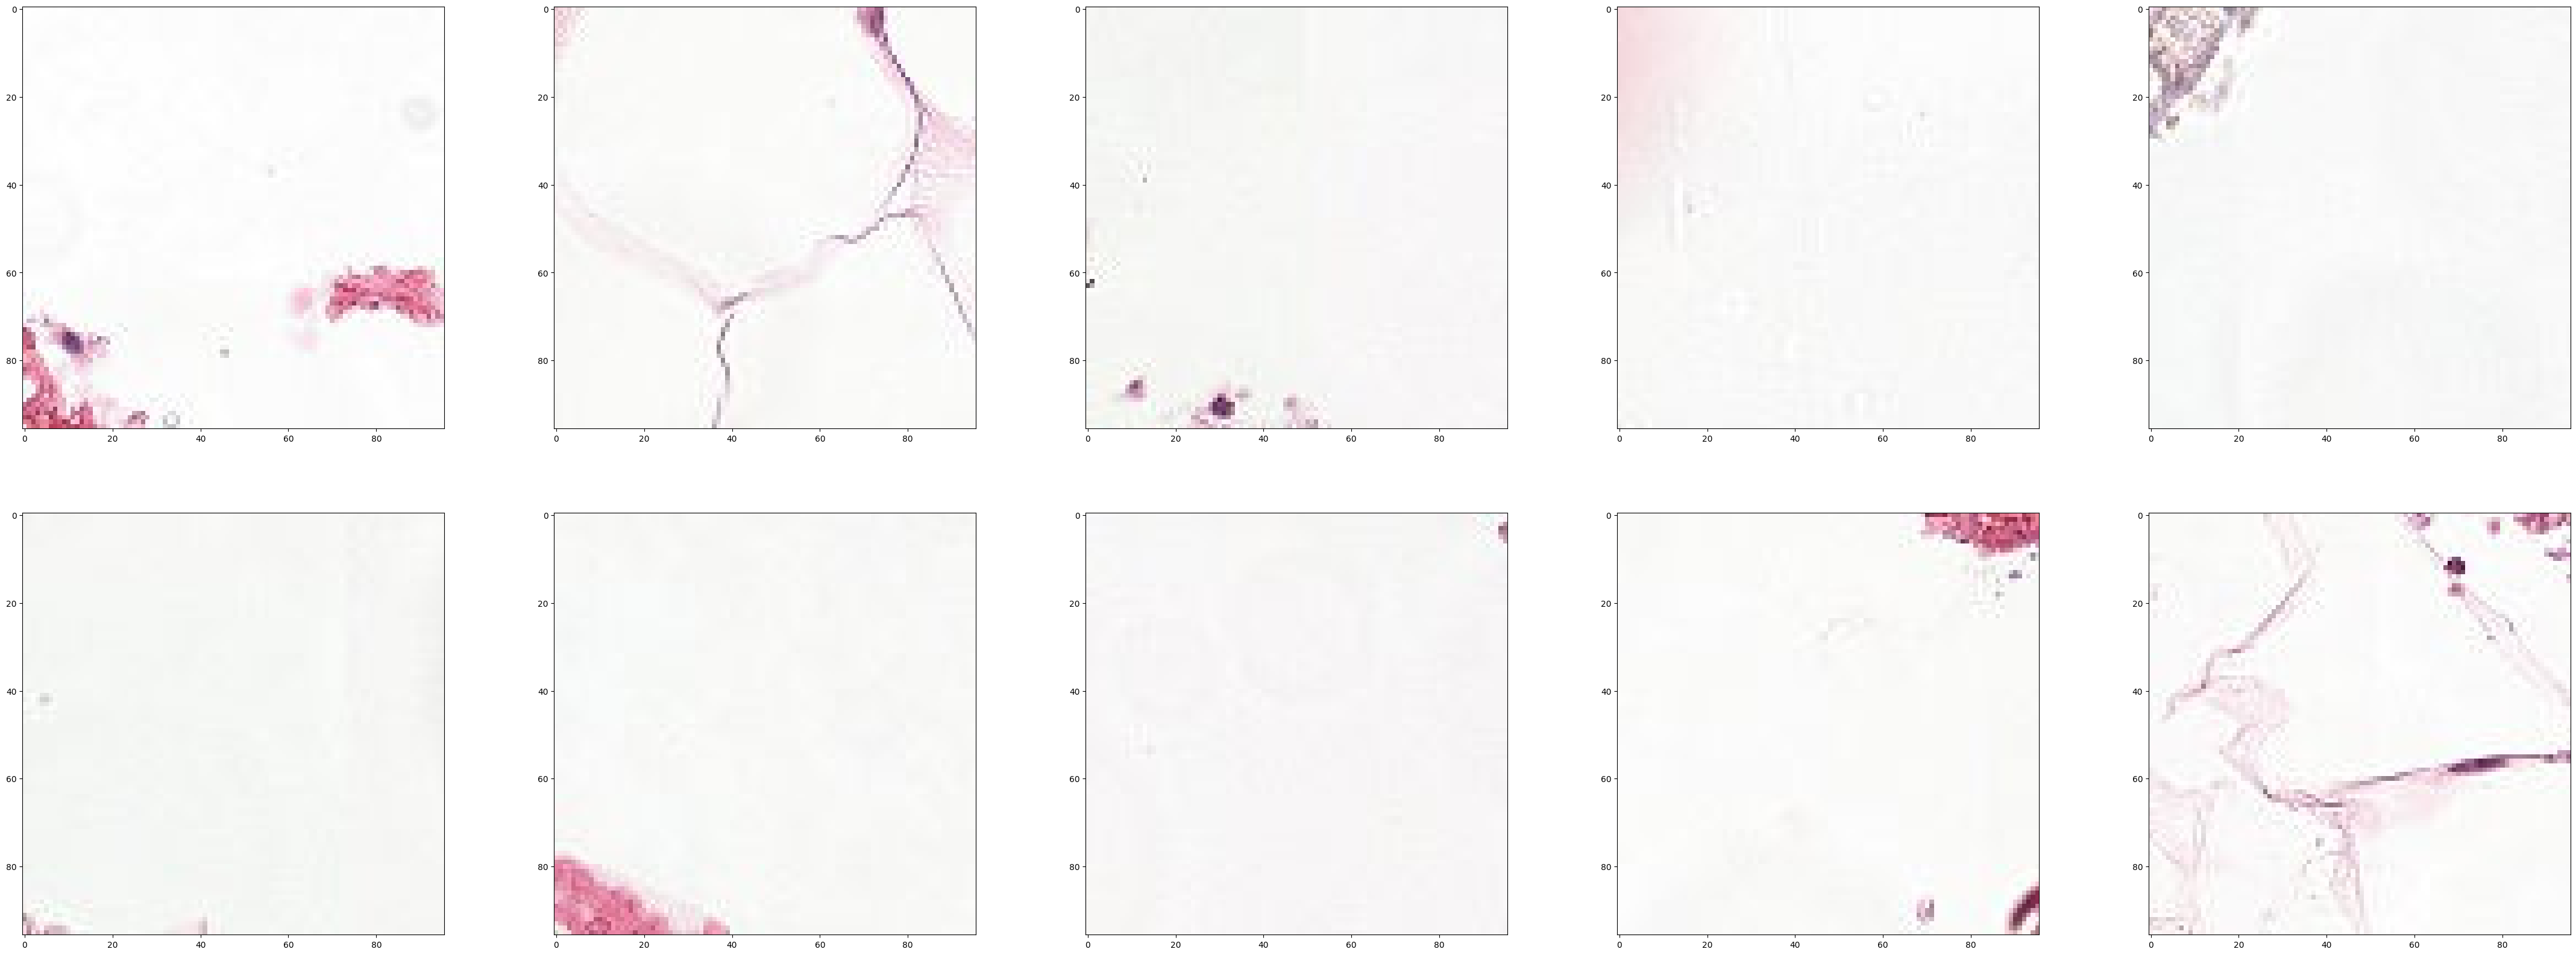

In [ ]:
print('number of white image:', len(white_outliers))
plt.figure(figsize=(55, 20))

for i, id in enumerate(white_outliers[:10]):
    img_path = os.path.join(train, id)
    img = Image.open(img_path)
    plt.subplot(2,5,i+1)
    plt.imshow(img)

In [ ]:
# remove outliers from train_labels dataset
train_labels = train_labels[~train_labels['id'].isin(black_outliers + white_outliers)]


In [ ]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [ ]:
# remove outliers from the train directory

outliers = black_outliers + white_outliers

for filename in outliers:
    img_path = os.path.join(train, filename)
    if os.path.exists(img_path):
        os.remove(img_path)
    else:
        print(f"Warning: Image file {img_path} not found.")


In [ ]:
# 3. filenames
print("id in the train_label:", "\n",train_labels['id'].head())

print("\nid in the images:","\n", os.listdir(train)[:5])


id in the train_label: 
 0    f38a6374c348f90b587e046aac6079959adf3835
1    c18f2d887b7ae4f6742ee445113fa1aef383ed77
2    755db6279dae599ebb4d39a9123cce439965282d
3    bc3f0c64fb968ff4a8bd33af6971ecae77c75e08
4    068aba587a4950175d04c680d38943fd488d6a9d
Name: id, dtype: object

id in the images: 
 ['61d22cb117a58e9d874f43df1e8eb3a01bd558de.tif', '15485e4e26ad038e3324454e992058d8945bbd16.tif', '0c7643e068c12779fe1e2925e79b564addc7e8ea.tif', '1c4e127590fd620d6a24bad35931297f9b43ed65.tif', 'a4ebd93ff56e42790b7b21ae8c331b9c22e24913.tif']


In [ ]:
# add the .tif to the train_labels id columns to match with the id in the images
# b/c flow_from_dataframe require a match filenames

train_labels.id = train_labels.id+'.tif'

In [ ]:
# 4. convert label from integers to strings,
# b/c flow_from_dataframe expects string format for binary classification

train_labels['label'] = train_labels['label'].astype(str)

In [ ]:
# 5. The malignant and benign cases are imbalance and the original dataset is too big,
# To balance the dataset and smaller the dataset,  I set different sample_fraction values.
train_0 = train_labels[B].sample(frac = 0.068,random_state=42)
train_1 = train_labels[M].sample(frac = 0.1, random_state =42)

train_labels = pd.concat([train_0, train_1]).sample(frac=1, random_state=42).reset_index(drop = True)

train_labels = shuffle(train_labels)

In [ ]:
train_labels['label'].value_counts()

label
1    8912
0    8902
Name: count, dtype: int64

In [ ]:
# 6. split the dataset

train_labels, val_labels = train_test_split(train_labels, test_size=0.2, random_state=42)
print(train_labels.shape)
print(val_labels.shape)

(14251, 2)
(3563, 2)


In [ ]:
# 7. To increase the model's robustness, we apply normalization to the dataset to range [0,1]
# and generate different types of images based on the original images,
# such as slightly rotated images, shift width and height slightly and zoomed-in images.

image_size = 96
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=train,
    x_col='id',
    y_col='label',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='binary'
)


Found 14214 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 37 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_labels,
    directory=train,
    x_col='id',
    y_col='label',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = False
)


Found 3555 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 8 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn(


**Build Model**

For models, I plan to try different models starting from easy to complex models. Perform comparisons of their accuracy, loss and ROC curves.

1. Basic CNN Model:
 I will start with a basic CNN model, as it is easy to build and can be customized with different parameters based on the complexity of the dataset such as layers, pooling, and strides to avoid overfitting.

2. VGG16 Model:
 I would like to try with VGG16 model. It is deeper model with 16 layers. It can capture complex patterns from the dataset and achieve higher accuracy. It supports transfer learning with pre-trained weights that can reduce computation costs.

3. ResNet50 Model:
 I would like to try with ResNet50 model. ResNet50 like VGG16 supports transfer learning which requires less training time. It has 50 layers with residual connection, making it work well with deep neural networks and prevent vanishing gradient issues.

1.Basic CNN Model

In [ ]:
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', strides=(1, 1), input_shape=(image_size, image_size, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu', strides=(1, 1)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu', strides=(1, 1)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu', strides=(1, 1)),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('cnn_best_model.h5', monitor='val_loss', save_best_only=True)

cnn = cnn_model.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=[early_stopping, model_checkpoint])

Epoch 1/10
223/223 [==============================] - 52s 227ms/step - loss: 0.5656 - accuracy: 0.7017 - val_loss: 0.7090 - val_accuracy: 0.6512
Epoch 2/10
223/223 [==============================] - 47s 212ms/step - loss: 0.4950 - accuracy: 0.7697 - val_loss: 0.5349 - val_accuracy: 0.7364
Epoch 3/10
223/223 [==============================] - 48s 214ms/step - loss: 0.4723 - accuracy: 0.7835 - val_loss: 0.4748 - val_accuracy: 0.7862
Epoch 4/10
223/223 [==============================] - 51s 229ms/step - loss: 0.4687 - accuracy: 0.7866 - val_loss: 0.5412 - val_accuracy: 0.7387
Epoch 5/10
223/223 [==============================] - 53s 239ms/step - loss: 0.4541 - accuracy: 0.7930 - val_loss: 0.4544 - val_accuracy: 0.7994
Epoch 6/10
223/223 [==============================] - 50s 224ms/step - loss: 0.4444 - accuracy: 0.8009 - val_loss: 0.5019 - val_accuracy: 0.7679
Epoch 7/10
223/223 [==============================] - 48s 216ms/step - loss: 0.4343 - accuracy: 0.8007 - val_loss: 0.4996 - val_ac

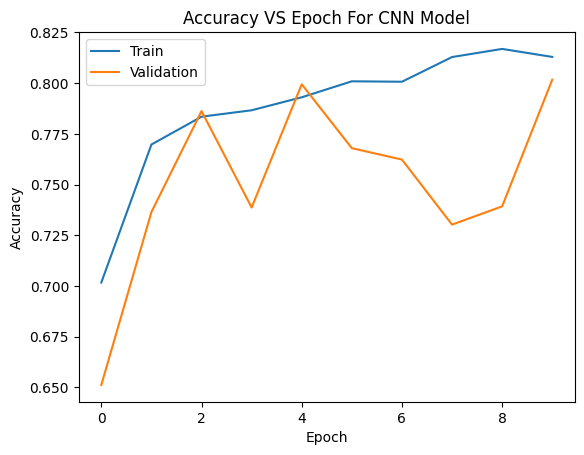

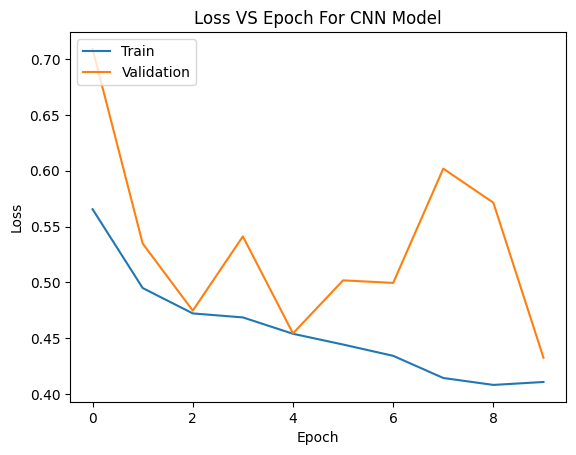

In [ ]:
plt.plot(cnn.history['accuracy'])
plt.plot(cnn.history['val_accuracy'])
plt.title('Accuracy VS Epoch For CNN Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(cnn.history['loss'])
plt.plot(cnn.history['val_loss'])
plt.title('Loss VS Epoch For CNN Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
val_generator.reset()
y_pred = cnn_model.predict(val_generator)
y_true = val_generator.classes

56/56 [==============================] - 4s 62ms/step


In [ ]:
roc_auc_cnn = roc_auc_score(y_true, y_pred)
print(f'ROC curve area: {roc_auc_cnn}')

ROC curve area: 0.9057902206624305


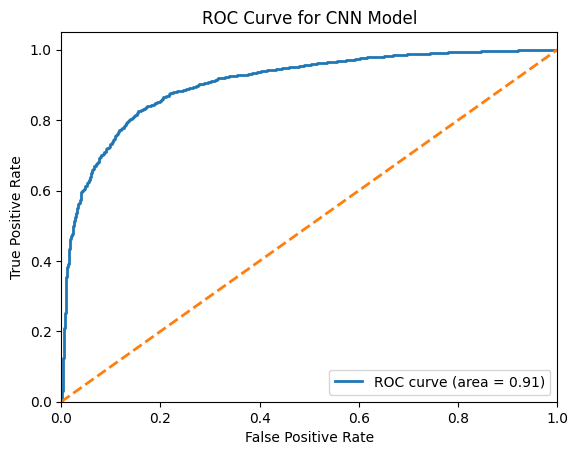

In [ ]:

fpr, tpr, _ = roc_curve(y_true, y_pred)

plt.figure()
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc_cnn:.2f})')
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CNN Model')
plt.legend(loc="lower right")
plt.show()

2. VGG16 model


In [ ]:
vgg_base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
x =vgg_base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

vgg16_model = Model(inputs=vgg_base_model.input, outputs=predictions)

for layer in vgg_base_model.layers:
    layer.trainable = False

vgg16_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('vgg_best_model.h5', monitor='val_loss', save_best_only=True)

vgg16 = vgg16_model.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=[early_stopping, model_checkpoint])

Epoch 1/10
223/223 [==============================] - 55s 246ms/step - loss: 0.4540 - accuracy: 0.7872 - val_loss: 0.4023 - val_accuracy: 0.8253
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


223/223 [==============================] - 52s 232ms/step - loss: 0.4231 - accuracy: 0.8041 - val_loss: 0.3879 - val_accuracy: 0.8267
Epoch 3/10
223/223 [==============================] - 52s 233ms/step - loss: 0.4173 - accuracy: 0.8058 - val_loss: 0.3896 - val_accuracy: 0.8239
Epoch 4/10
223/223 [==============================] - 52s 232ms/step - loss: 0.4097 - accuracy: 0.8105 - val_loss: 0.3767 - val_accuracy: 0.8338
Epoch 5/10
223/223 [==============================] - 52s 232ms/step - loss: 0.4013 - accuracy: 0.8131 - val_loss: 0.3752 - val_accuracy: 0.8315
Epoch 6/10
223/223 [==============================] - 56s 252ms/step - loss: 0.3968 - accuracy: 0.8202 - val_loss: 0.3593 - val_accuracy: 0.8430
Epoch 7/10
223/223 [==============================] - 51s 228ms/step - loss: 0.3925 - accuracy: 0.8189 - val_loss: 0.3603 - val_accuracy: 0.8414
Epoch 8/10
223/223 [==============================] - 55s 247ms/step - loss: 0.3895 - accuracy: 0.8214 - val_loss: 0.3561 - val_accuracy: 0.8

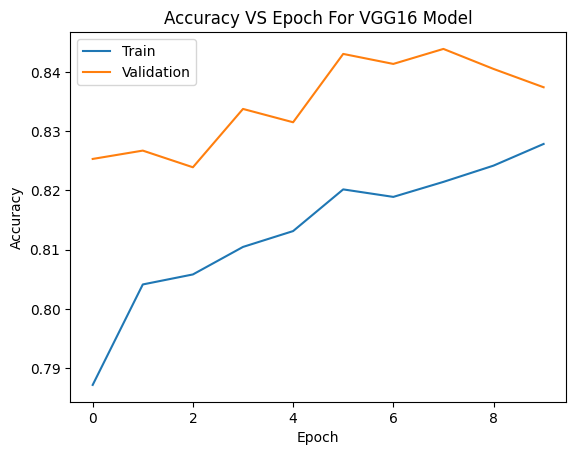

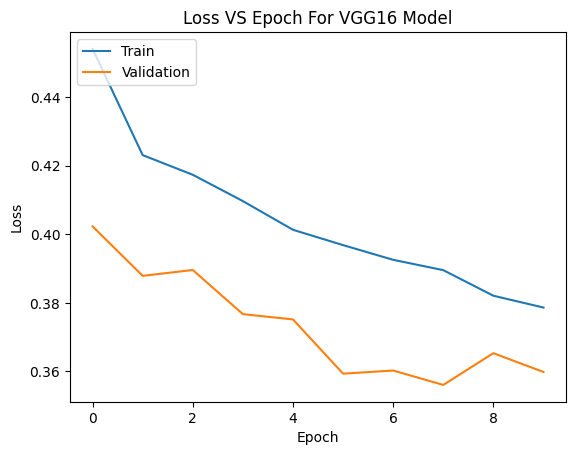

In [ ]:
plt.plot(vgg16.history['accuracy'])
plt.plot(vgg16.history['val_accuracy'])
plt.title('Accuracy VS Epoch For VGG16 Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(vgg16.history['loss'])
plt.plot(vgg16.history['val_loss'])
plt.title('Loss VS Epoch For VGG16 Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
val_generator.reset()
vgg16_ypred = vgg16_model.predict(val_generator)
vgg16_y = val_generator.classes

56/56 [==============================] - 3s 57ms/step


In [ ]:

roc_auc_vgg16 = roc_auc_score(vgg16_y, vgg16_ypred)
print(f'ROC curve area: {roc_auc_vgg16}')

ROC curve area: 0.9214742311505111


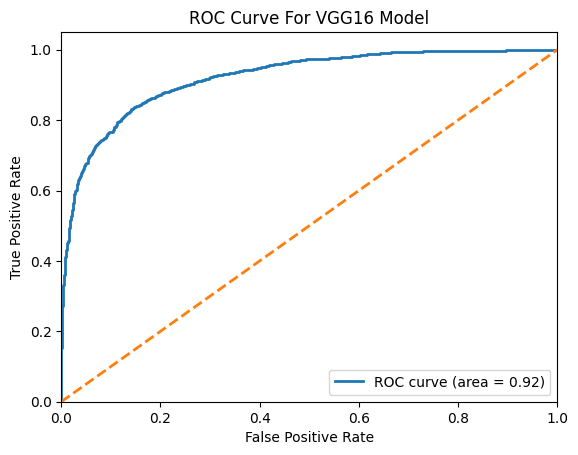

In [ ]:
fpr, tpr, _ = roc_curve(vgg16_y, vgg16_ypred)

plt.figure()
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc_vgg16:.2f})')
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve For VGG16 Model')
plt.legend(loc="lower right")
plt.show()



3. Build ResNet50


In [ ]:
from keras.applications import ResNet50

ResN_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

x = ResN_base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

ResN_model = Model(inputs=ResN_base_model.input, outputs=predictions)

for layer in ResN_base_model.layers:
    layer.trainable = False

ResN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('ResN_best_model.h5', monitor='val_loss', save_best_only=True)

ResN = ResN_model.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=[early_stopping, model_checkpoint])

Epoch 1/10
223/223 [==============================] - ETA: 0s - loss: 0.7019 - accuracy: 0.5708

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


223/223 [==============================] - 63s 257ms/step - loss: 0.7019 - accuracy: 0.5708 - val_loss: 0.6711 - val_accuracy: 0.5252
Epoch 2/10
223/223 [==============================] - 52s 232ms/step - loss: 0.6600 - accuracy: 0.6076 - val_loss: 0.6291 - val_accuracy: 0.6537
Epoch 3/10
223/223 [==============================] - 52s 231ms/step - loss: 0.6363 - accuracy: 0.6442 - val_loss: 0.6229 - val_accuracy: 0.6869
Epoch 4/10
223/223 [==============================] - 52s 232ms/step - loss: 0.6251 - accuracy: 0.6527 - val_loss: 0.6292 - val_accuracy: 0.6807
Epoch 5/10
223/223 [==============================] - 52s 232ms/step - loss: 0.6177 - accuracy: 0.6665 - val_loss: 0.6255 - val_accuracy: 0.6833
Epoch 6/10
223/223 [==============================] - 54s 244ms/step - loss: 0.6199 - accuracy: 0.6575 - val_loss: 0.6268 - val_accuracy: 0.6785
Epoch 7/10
223/223 [==============================] - 53s 240ms/step - loss: 0.6184 - accuracy: 0.6641 - val_loss: 0.6250 - val_accuracy: 0.6

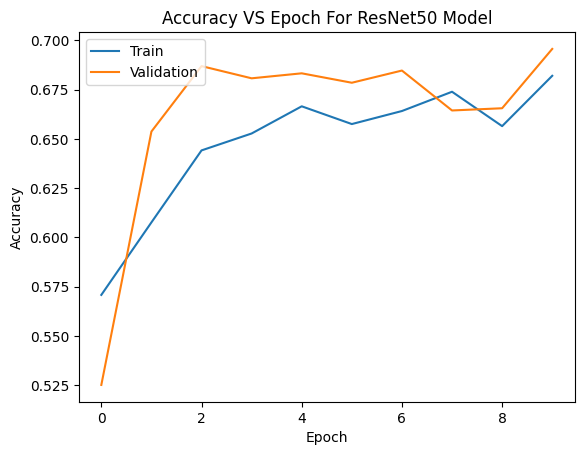

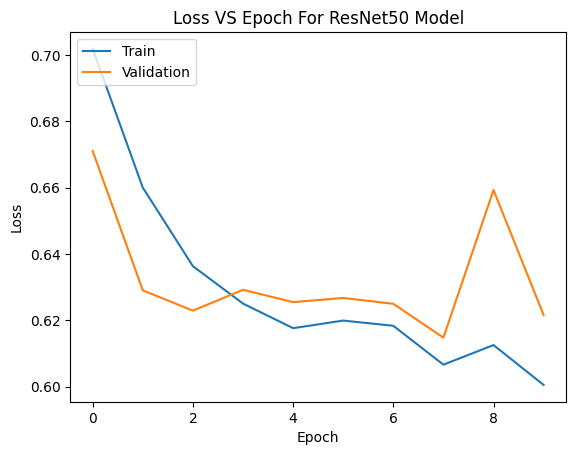

In [ ]:
plt.plot(ResN.history['accuracy'])
plt.plot(ResN.history['val_accuracy'])
plt.title('Accuracy VS Epoch For ResNet50 Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(ResN.history['loss'])
plt.plot(ResN.history['val_loss'])
plt.title('Loss VS Epoch For ResNet50 Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
val_generator.reset()
ResN_ypred = ResN_model.predict(val_generator)
ResN_y = val_generator.classes

56/56 [==============================] - 9s 81ms/step


In [ ]:

roc_auc_ResN = roc_auc_score(ResN_y, ResN_ypred)
print(f'ROC curve area: {roc_auc_ResN}')

ROC curve area: 0.7775282047581247


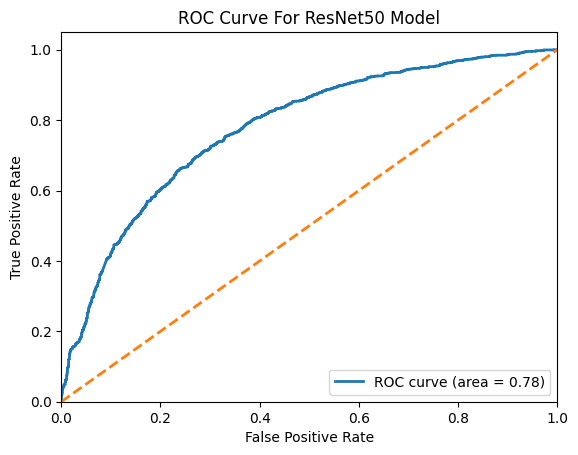

In [ ]:
fpr, tpr, _ = roc_curve(ResN_y, ResN_ypred)

plt.figure()
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc_ResN:.2f})')
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve For ResNet50 Model')
plt.legend(loc="lower right")
plt.show()

Summary Table Before Hyperparameter Tuning

In [ ]:
from tabulate import tabulate

cnn_table = [0.8129, 0.4109, 0.8017, 0.4326, 0.9058]
VGG16_table = [0.8278, 0.3786, 0.8374, 0.3598, 0.9215 ]
ResN50_table = [0.6820, 0.6005, 0.6956, 0.6216, 0.7775]

data = [
    ['CNN'] + cnn_table,
    ['VGG16'] + VGG16_table,
    ['ResNet50'] + ResN50_table,
]

headers = ['Models', 'Train data Accuracy', 'Train data Loss', 'Validation data Accuracy', 'Validation data Loss', 'ROC Curve Area']

table = tabulate(data, headers=headers, tablefmt='grid')

print(table)

+----------+-----------------------+-------------------+----------------------------+------------------------+------------------+
| Models   |   Train data Accuracy |   Train data Loss |   Validation data Accuracy |   Validation data Loss |   ROC Curve Area |
+==========+=======================+===================+============================+========================+==================+
| CNN      |                0.8129 |            0.4109 |                     0.8017 |                 0.4326 |           0.9058 |
+----------+-----------------------+-------------------+----------------------------+------------------------+------------------+
| VGG16    |                0.8278 |            0.3786 |                     0.8374 |                 0.3598 |           0.9215 |
+----------+-----------------------+-------------------+----------------------------+------------------------+------------------+
| ResNet50 |                0.682  |            0.6005 |                     0.6956 |     

# Hyperparameter Tuning for VGG16

 From the accuracy and loss plots. we can see that VGG16 has the highest accuracy, lowest loss and highest ROC Curve area. So we chose the VGG16 model for hyperparameter tuning.

In [ ]:
def vgg16_hyper(hp):
  vgg_base_model2 = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
  x = vgg_base_model2.output
  x = Flatten()(x)

  units = hp.Int('units', min_value=256, max_value=512, step =64)
  x = Dense(units, activation = 'relu')(x)

  rate = hp.Float('dropout_rate', min_value = 0.5, max_value=0.7, step = 0.1)
  x = Dropout(rate)(x)

  predictions = Dense(1, activation='sigmoid')(x)

  vgg16_model2 = Model(inputs = vgg_base_model2.input, outputs = predictions)

  for layer in vgg_base_model2.layers:
    layer.trainable= False

    learning_rate = hp.Float('learning_rate', min_value = 1e-5, max_value = 1e-3, sampling='log')
    vgg16_model2.compile(optimizer=Adam(learning_rate=learning_rate), loss = 'binary_crossentropy', metrics=['accuracy'])

    return vgg16_model2

In [ ]:
pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.0 MB/s eta 0:00:00


In [ ]:
from keras_tuner import RandomSearch

tuner = RandomSearch(
    vgg16_hyper,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir',
    project_name='vgg16_tuning'
)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('vgg_best_model2.h5', monitor='val_loss', save_best_only=True)

In [ ]:
tuner.search(train_generator, epochs=10, validation_data=val_generator, callbacks=[early_stopping, model_checkpoint])


Trial 10 Complete [00h 25m 26s]
val_accuracy: 0.9113924205303192

Best val_accuracy So Far: 0.926300972700119
Total elapsed time: 03h 46m 14s


In [ ]:
best_hypers = tuner.get_best_hyperparameters(num_trials=1)[0]


In [ ]:
print(f"""
Best hyperparameters for VGG16 model are:
{best_hypers.get('units')} units in the dense layer.
{best_hypers.get('dropout_rate')} dropout rate.
{best_hypers.get('learning_rate')} learning rate for the optimizer.
""")


Best hyperparameters for VGG16 model are:
512 units in the dense layer.
0.6 dropout rate.
5.405375683012969e-05 learning rate for the optimizer.



In [ ]:
vgg16_model_best = tuner.hypermodel.build(best_hypers)
vgg16_best = vgg16_model_best.fit(train_generator, epochs=10, validation_data = val_generator, callbacks=[early_stopping, model_checkpoint])

Epoch 1/10
223/223 [==============================] - 75s 320ms/step - loss: 0.4416 - accuracy: 0.7900 - val_loss: 0.3367 - val_accuracy: 0.8560
Epoch 2/10
223/223 [==============================] - 65s 290ms/step - loss: 0.3522 - accuracy: 0.8467 - val_loss: 0.3481 - val_accuracy: 0.8430
Epoch 3/10
223/223 [==============================] - 67s 301ms/step - loss: 0.3026 - accuracy: 0.8684 - val_loss: 0.2454 - val_accuracy: 0.9069
Epoch 4/10
223/223 [==============================] - 70s 312ms/step - loss: 0.2723 - accuracy: 0.8864 - val_loss: 0.2492 - val_accuracy: 0.9038
Epoch 5/10
223/223 [==============================] - 68s 305ms/step - loss: 0.2376 - accuracy: 0.9016 - val_loss: 0.2226 - val_accuracy: 0.9173
Epoch 6/10
223/223 [==============================] - 62s 278ms/step - loss: 0.2195 - accuracy: 0.9122 - val_loss: 0.2049 - val_accuracy: 0.9274
Epoch 7/10
223/223 [==============================] - 60s 269ms/step - loss: 0.1989 - accuracy: 0.9199 - val_loss: 0.2698 - val_ac

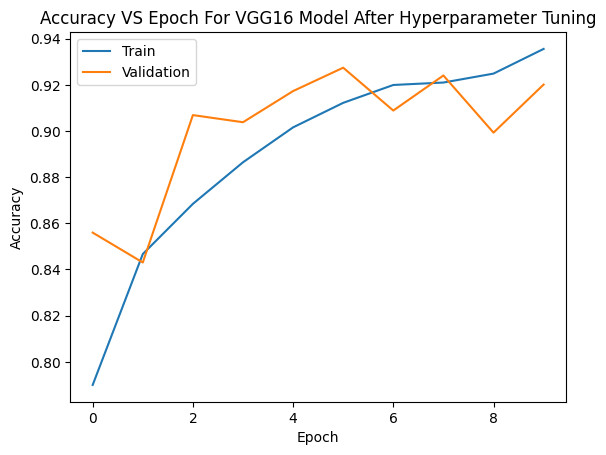

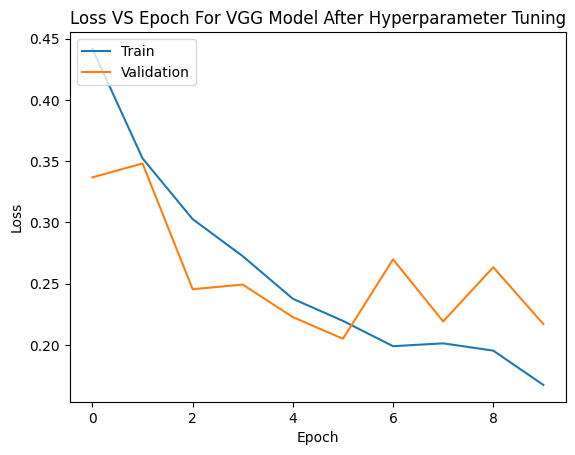

In [ ]:
plt.plot(vgg16_best.history['accuracy'])
plt.plot(vgg16_best.history['val_accuracy'])
plt.title('Accuracy VS Epoch For VGG16 Model After Hyperparameter Tuning')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(vgg16_best.history['loss'])
plt.plot(vgg16_best.history['val_loss'])
plt.title('Loss VS Epoch For VGG Model After Hyperparameter Tuning')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
val_generator.reset()
vgg16_ypred_best= vgg16_model_best.predict(val_generator)
vgg16_y_best = val_generator.classes

56/56 [==============================] - 4s 59ms/step


In [ ]:

roc_auc = roc_auc_score(vgg16_y_best, vgg16_ypred_best)
print(f'ROC curve area: {roc_auc}')

ROC curve area: 0.9730274394219653


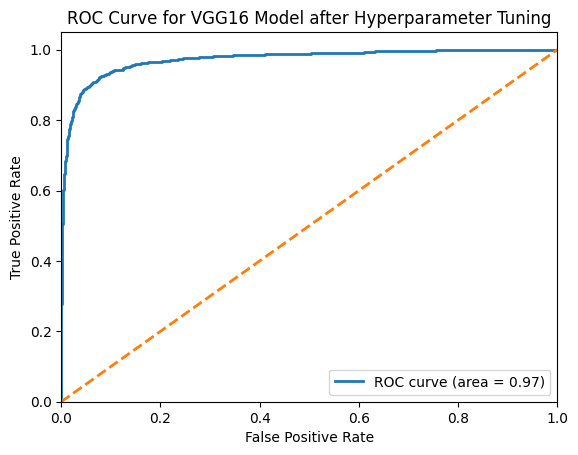

In [ ]:

fpr, tpr, _ = roc_curve(vgg16_y_best, vgg16_ypred_best)

plt.figure()
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for VGG16 Model after Hyperparameter Tuning')
plt.legend(loc="lower right")
plt.show()

### Summary Table

In [ ]:
from tabulate import tabulate

cnn_table = [0.8129, 0.4109, 0.8017, 0.4326, 0.9058]
VGG16_table = [0.8278, 0.3786, 0.8374, 0.3598, 0.9215 ]
ResN50_table = [0.6820, 0.6005, 0.6956, 0.6216, 0.7775]
VGG16_best_table = [0.9356, 0.1672, 0.9201, 0.2169, 0.9730]

data = [
    ['CNN'] + cnn_table,
    ['VGG16'] + VGG16_table,
    ['ResNet50'] + ResN50_table,
    ['VGG16 (After Hyperparameter Tuning)'] + VGG16_best_table
]

headers = ['Models', 'Train data Accuracy', 'Train data Loss', 'Validation data Accuracy', 'Validation data Loss', 'ROC Curve Area']

table = tabulate(data, headers=headers, tablefmt='grid')

print(table)


+-------------------------------------+-----------------------+-------------------+----------------------------+------------------------+------------------+
| Models                              |   Train data Accuracy |   Train data Loss |   Validation data Accuracy |   Validation data Loss |   ROC Curve Area |
+=====================================+=======================+===================+============================+========================+==================+
| CNN                                 |                0.8129 |            0.4109 |                     0.8017 |                 0.4326 |           0.9058 |
+-------------------------------------+-----------------------+-------------------+----------------------------+------------------------+------------------+
| VGG16                               |                0.8278 |            0.3786 |                     0.8374 |                 0.3598 |           0.9215 |
+-------------------------------------+-------------------

1. Analysis:

From the accuracy and loss plots, we can see that the
VGG16 model has the best performance.

VGG16 model outperformed the CNN model. Firstly, the VGG16 model is a deeper model compare with the four layer CNN model, Which allows the VGG16 model to capture more complex patterns. Secondly, VGG16 supports transfer learning which helps fine-tune the model based on the dataset and reduce the computation cost.

ResNet50 had the worst performance. Because the ResNet50 have 50 layers and the dataset is too simple for ResNet50 model.

2. Hyperparameter tuning summary:

VGG16 has the highest accuracy, lowest loss and best ROC Curve area. The validation dataset outperformed the training dataset, So I chose the VGG16 model for hyperparameter tuning.

Pre-defined hyperparameter tuning rangs:
1. dense units from 256 to 512.
2. dropout rate from 0.5 to 0.7
3. learning rates from 1e-5 to 1e-3.

I used the Keras tuner with the random search for hyperparameter tuning because it randomly picks parameters which will help prevent overfitting, less computation cost and can potentially explore more broadly hyperparameters value.

The result show:

  Best hyperparameters for VGG16 model are:

    512 units in the dense layer.

    0.6 dropout rate.

    5.405375683012969e-05 learning rate for the optimizer.

After retrain the model with the best parameters. The performance of the model has increased significantly. Please see the summary table.


# Predict On The Test Image Directory:


In [ ]:
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test = 'HCD/test/'

test_df = pd.DataFrame(os.listdir(test), columns=['id'])


test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test,
    x_col='id',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode=None,
    shuffle = False
)

pred = vgg16_model_best.predict(test_generator)



threshold = 0.5
binary_predictions = (pred > threshold).astype(int)
test_df['label'] = binary_predictions
test_df.id = test_df.id.str.replace('.tif', '')
test_df.to_csv('predictions.csv', index=False)
from google.colab import files

files.download('predictions.csv')

Found 57458 validated image filenames.
898/898 [==============================] - 87s 97ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Conclusion:


After performing hyperparameter tuning using the random search tuner, the performance of the VGG16 model improved significantly. The training, validation data accuracy and the roc curve area all increased. The loss decreased.

Learning and Takeaways:

CNN model is good for beginning, it is simple and can be customizable base on the dataset.

VGG16 model support transfer learning can help extract features and capture complex patterns to achieve higher accuracy.

RestNet50 works well with deep networks and complex datasets. It is too complex for a simple dataset.

Keras tuner with the random search is great for hyperparameter tuning for deep learning. It doesnot run all of the combinations like grid search. It picks parameters randomly within the parameter range. Which potentially has more options than grid search and reduces the computation cost.

Improvements:

Due to the limitation of the GPU, I cut the dataset to a smaller size. If I have access to more GPU, I would be interested in running the whole dataset on the ResNet50 model. Compare the result with CNN and VGG16.

### Reference:



1. Mrjustpeachy. (2024, June 11). CNN Histopathologic cancer detection. Kaggle. https://www.kaggle.com/code/mrjustpeachy/cnn-histopathologic-cancer-detection


2. Srujanapalli. (2024, February 10). Histopathologic Cancer Detection CNN. Kaggle. https://www.kaggle.com/code/srujanapalli/histopathologic-cancer-detection-cnn


3. Fmarazzi. (2018, November 26). Baseline Keras CNN - ROC - FAST (10min) (0.925 LB). Kaggle. https://www.kaggle.com/code/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb


4. Sdelecourt. (2019, January 1). CNN with Keras. Kaggle. https://www.kaggle.com/code/sdelecourt/cnn-with-keras


5. Qitvision. (2019, March 6). A complete ML pipeline (Fast.ai). Kaggle. https://www.kaggle.com/code/qitvision/a-complete-ml-pipeline-fast-ai

6. Queiroz, V. (2023, March 22). Using KERAS Tuner to find the best hyperparameters for your neural network model. Medium. https://medium.com/@viniciusqroz/using-keras-tuner-to-find-the-best-parameters-for-your-neural-network-model-2dc02e0a1203